In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RepeatedKFold, KFold
from scipy.stats import zscore

In [6]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
train_validation = pd.read_csv(DIRECTORY + 'sales_train_validation.csv')
prices = pd.read_csv(DIRECTORY + 'sell_prices.csv')

## Setup row-wise DF

In [7]:
train_validation[[f'd_{i}' for i in range(1914, 1942)]] = np.nan
train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
drop_cols = [f'd_{i}' for i in range(1, 1100)]
train_validation = train_validation.drop(columns=drop_cols, errors='ignore')

In [11]:
# Convert to row wise
row_wise = train_validation.copy()
row_wise = row_wise.melt(id_vars=[col for col in train_validation.columns if 'id' in col], var_name='day', value_name='sales')

# Change all object cols to category
for col in row_wise.select_dtypes('object').columns:
    row_wise[col] = row_wise[col].astype('category')

In [12]:
# Merge calendar
calendar['d'] = calendar['d'].astype('category')
row_wise = row_wise.merge(calendar[['date', 'wm_yr_wk', 'event_name_1', 'snap_CA', 'snap_TX', 'snap_WI', 'd']],\
                how='left', left_on='day', right_on='d')

In [13]:
# Merge in sale price
row_wise = row_wise.merge(prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])

In [14]:
# Save data
for col in row_wise.select_dtypes('object'):
    row_wise[col] = row_wise[col].astype('category')
for col in row_wise.select_dtypes('int'):
    row_wise[col] = pd.to_numeric(row_wise[col], downcast='integer')
for col in row_wise.select_dtypes('float'):
    row_wise[col] = pd.to_numeric(row_wise[col], downcast='float')
row_wise.dtypes

id                    category
item_id               category
dept_id               category
cat_id                category
store_id              category
state_id              category
day                   category
sales                  float32
date            datetime64[ns]
wm_yr_wk                 int16
event_name_1          category
snap_CA                   int8
snap_TX                   int8
snap_WI                   int8
d                     category
sell_price             float32
dtype: object

In [15]:
# Drop no sale price cols
row_wise['sell_price'].isna().value_counts()
row_wise = row_wise[row_wise['sell_price'].notna()]

## Feature Engineering

In [16]:
# Filter days
row_wise['day'] = row_wise['day'].str.split('_').str[1].astype(int)
test_start = 1159+28
row_wise = row_wise[row_wise['day'] >= test_start]

In [17]:
# Make single SNAP column
state_map = {"CA": 0, "WI": 1, "TX": 2}
snap_values = row_wise[["snap_CA", "snap_WI", "snap_TX"]].to_numpy()
row_wise['snap'] = snap_values[np.arange(len(row_wise)), row_wise["state_id"].map(state_map).to_numpy()]
del state_map, snap_values

In [18]:
# Delete useless features
useless = ['d', 'snap_CA', 'snap_TX', 'snap_WI']
row_wise = row_wise.drop(columns=useless)

In [19]:
# Basic event features
def add_event_features(df):
    df['is_event'] = df['event_name_1'].notna()

    event_per_day = df.groupby("day")["event_name_1"].first()
    df["event_name_tmrw"] = df["day"].map(event_per_day.shift(-1))
    df["event_name_yday"] = df["day"].map(event_per_day.shift(1))

    df["is_event_tmrw"] = df["event_name_tmrw"].notna()
    df["is_event_yday"] = df["event_name_yday"].notna()

add_event_features(row_wise)

In [20]:
def add_date_features(df):
    df['day_of_week'] = df['date'].dt.day_of_week
    df['year'] = df['date'].dt.year
    df['year_sin'] = np.sin(2*np.pi * df['date'].dt.day / 365)
    df['year_cos'] = np.cos(2*np.pi * df['date'].dt.day / 365)
    df['month'] = df['date'].dt.month

add_date_features(row_wise)

In [21]:
def add_price_features(df):
    group = df.groupby("id")["sell_price"]
    mean_per_id = group.transform('mean')
    std_per_id = group.transform('std').fillna(0)
    df["sell_price_zscore"] = np.where(std_per_id == 0, 0, (df['sell_price'] - mean_per_id)/std_per_id)

    def add_detrended_zscore(groups):
        if not groups: groups = []
        groups = groups + ['wm_yr_wk']

        avg_zscore_group = df.groupby(groups)["sell_price_zscore"].transform("mean")
        df[f"sell_price_zscore_{'_'.join(groups)}"]  = df['sell_price_zscore'] / avg_zscore_group

    for groups in [None]: add_detrended_zscore(groups)

add_price_features(row_wise)

/tmp/ipykernel_826786/435921784.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby("id")["sell_price"]


In [22]:
def add_sales_features(df):
    df["ewm_sales_alpha_005"] = df.groupby("id")["sales"].transform(lambda x: x.ewm(alpha=0.05).mean())
    df['ewm_sales_alpha_005'] = df.groupby('id')['ewm_sales_alpha_005'].shift(1).fillna(0)

    df['zero_sales'] = df['sales'] == 0
    df["ewm_zero_sales_alpha_10"] = df.groupby("id")["zero_sales"].transform(lambda x: x.ewm(alpha=0.10).mean())
    df["ewm_zero_sales_alpha_10"] = df.groupby("id")["ewm_zero_sales_alpha_10"].shift(1).fillna(1)

    # group = df.groupby("id")["sales"]
    # mean_per_id = group.transform('mean')
    # std_per_id = group.transform('std').fillna(0)
    # df["sales_zscore"] = np.where(std_per_id == 0, 0, (df['sales'] - mean_per_id)/std_per_id)

    # def rolling_avg_zscore(group_col):
    #     if group_col is None: group_col = ['id']

    #     # Step 1: Compute daily average z-score per group
    #     daily_avg_zscore = df.groupby(group_col + ["day"])["sales_zscore"].mean().reset_index()
    #     daily_avg_zscore['sales_zscore_7d_avg'] = daily_avg_zscore.groupby(group_col)["sales_zscore"].transform(lambda x: x.rolling(7, min_periods=1).mean())

    #     df[f"sales_zscore_rolling7_{'_'.join(group_col)}"] = df.groupby(group_col)["sales_zscore"].transform(lambda x: x.rolling(7, min_periods=1, closed='left').mean())
    # for group in [None, ['dept_id', 'store_id']]:
    #     rolling_avg_zscore(group)

# Zero out sales for test period
add_sales_features(row_wise)

/tmp/ipykernel_826786/1498176769.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["ewm_sales_alpha_005"] = df.groupby("id")["sales"].transform(lambda x: x.ewm(alpha=0.05).mean())
/tmp/ipykernel_826786/1498176769.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['ewm_sales_alpha_005'] = df.groupby('id')['ewm_sales_alpha_005'].shift(1).fillna(0)
/tmp/ipykernel_826786/1498176769.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

## Modelling

In [23]:
# Remove leakage cols
drop_cols = ['sales_zscore', 'sales_zscore_rolling7_id', 'sales_zscore_rolling7_dept_id_store_id', 'date', 'zero_sales', 'zero_sales_yday']
row_wise = row_wise.drop(columns=drop_cols, errors='ignore')
row_wise.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'sales', 'wm_yr_wk', 'event_name_1', 'sell_price', 'snap', 'is_event',
       'event_name_tmrw', 'event_name_yday', 'is_event_tmrw', 'is_event_yday',
       'day_of_week', 'year', 'year_sin', 'year_cos', 'month',
       'sell_price_zscore', 'sell_price_zscore_wm_yr_wk',
       'ewm_sales_alpha_005', 'ewm_zero_sales_alpha_10'],
      dtype='object')

In [24]:
test_start = 1913+1
train = row_wise[row_wise['day'] < test_start]
test = row_wise[row_wise['day'] >= test_start]

# id_cols = [col for col in train if 'id' in col]
# train[id_cols] = train[id_cols].astype('category')
# test[id_cols] = test[id_cols].astype('category')

In [25]:
params = {
    'n_estimators':5000
    ,'learning_rate':0.1
    ,'verbosity':0
    ,'enable_categorical':True
    ,'early_stopping_rounds':10
    ,'random_state':42
    ,'objective':'reg:tweedie'
    ,'tweedie_variance_power': 1.5
    ,'eval_metric':'rmse'
    ,'device':'cuda'
    ,'reg_lambda':0
    ,'min_child_weight':1
}

In [26]:
n_splits=2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

X_test, y_test = test.drop(columns='sales'), test['sales']

oof_preds = pd.DataFrame(index=train.index, columns=['prediction', 'actual'])
oof_preds['actual'] = train['sales']

test_preds = pd.DataFrame(index=test.index, columns=[f'fold_{i}' for i in range(n_splits)])
test_preds['actual'] = y_test

for i, (train_idx, val_idx) in enumerate(kf.split(train)):
    X_train, y_train = train.iloc[train_idx].drop(columns='sales'), train.iloc[train_idx]['sales']
    X_val, y_val = train.iloc[val_idx].drop(columns='sales'), train.iloc[val_idx]['sales']

    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

    model_oof_preds = xgb_model.predict(X_val).clip(0)
    model_test_preds = xgb_model.predict(X_test).clip(0)

    oof_preds.iloc[val_idx,0] = model_oof_preds
    test_preds.iloc[:,i] = model_test_preds

[0]	validation_0-rmse:3.58455
[100]	validation_0-rmse:2.12457
[200]	validation_0-rmse:2.11731
[300]	validation_0-rmse:2.11330
[351]	validation_0-rmse:2.11192
[0]	validation_0-rmse:3.58348
[100]	validation_0-rmse:2.12821
[200]	validation_0-rmse:2.12071
[256]	validation_0-rmse:2.11880


In [27]:
def get_rmse(col1, col2):
    return np.sqrt(np.mean((col1 - col2)**2))

# See OOF Naive RMSE
get_rmse(oof_preds['prediction'], oof_preds['actual'])

2.115270420573576

In [28]:
# Test df
get_rmse(test_preds['fold_0'], test_preds['actual'])
get_rmse(test_preds['fold_1'], test_preds['actual'])
get_rmse((test_preds['fold_0'] + test_preds['fold_1'])/2, test_preds['actual'])

nan

In [54]:
# Real metric
test['predictions'] = (test_preds['fold_0'] + test_preds['fold_1'])/2
test['predictions'] = test_preds['fold_1']

/tmp/ipykernel_826786/279236773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = (test_preds['fold_0'] + test_preds['fold_1'])/2
/tmp/ipykernel_826786/279236773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = test_preds['fold_1']


In [55]:
predictions = test.pivot(index='id', columns='day', values='predictions')
predictions = predictions.rename(columns={col : f'd_{col}' for col in predictions.columns})
predictions.to_csv('test_prediction.csv')

In [56]:
predictions.columns=[f'F{i}' for i in range(1, 29)]

In [57]:
train_evaluation = pd.read_csv(DIRECTORY + 'sales_train_evaluation.csv')
train_evaluation

predictions = pd.concat([predictions.reset_index(), train_evaluation[['id']]])
predictions = predictions.fillna(0)
predictions.to_csv('./xgb_fold1.csv', index=False)

/tmp/ipykernel_826786/1712020072.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.fillna(0)


In [49]:
predictions

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.949450,0.881651,0.884865,0.884865,1.036419,1.371677,1.507830,1.075199,1.012692,...,1.085556,1.412822,1.419714,0.993906,0.902581,0.901741,0.899996,1.063189,1.385176,1.391910
1,FOODS_1_001_CA_2_validation,1.077624,1.043750,1.007042,1.015456,1.224133,1.577131,1.860578,1.255114,1.230028,...,1.291407,1.679242,1.687229,1.087077,1.041030,1.040165,1.038227,1.269827,1.653525,1.661346
2,FOODS_1_001_CA_3_validation,0.955857,0.948204,0.982001,1.011308,1.164629,1.351835,1.588153,1.163687,1.102478,...,1.156774,1.488850,1.504967,1.085531,0.980826,0.966261,0.964389,1.126202,1.450704,1.463159
3,FOODS_1_001_CA_4_validation,0.441372,0.413228,0.410661,0.410523,0.426236,0.499327,0.574203,0.513813,0.473322,...,0.476634,0.541895,0.542690,0.493898,0.437745,0.429439,0.426960,0.462106,0.523911,0.524680
4,FOODS_1_001_TX_1_validation,0.115893,0.260817,0.312675,0.326540,0.354889,0.394669,0.505863,0.382184,0.387848,...,0.413458,0.447245,0.456077,0.389444,0.358972,0.356019,0.352518,0.381633,0.426190,0.428308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30486,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30487,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30488,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## SHAP

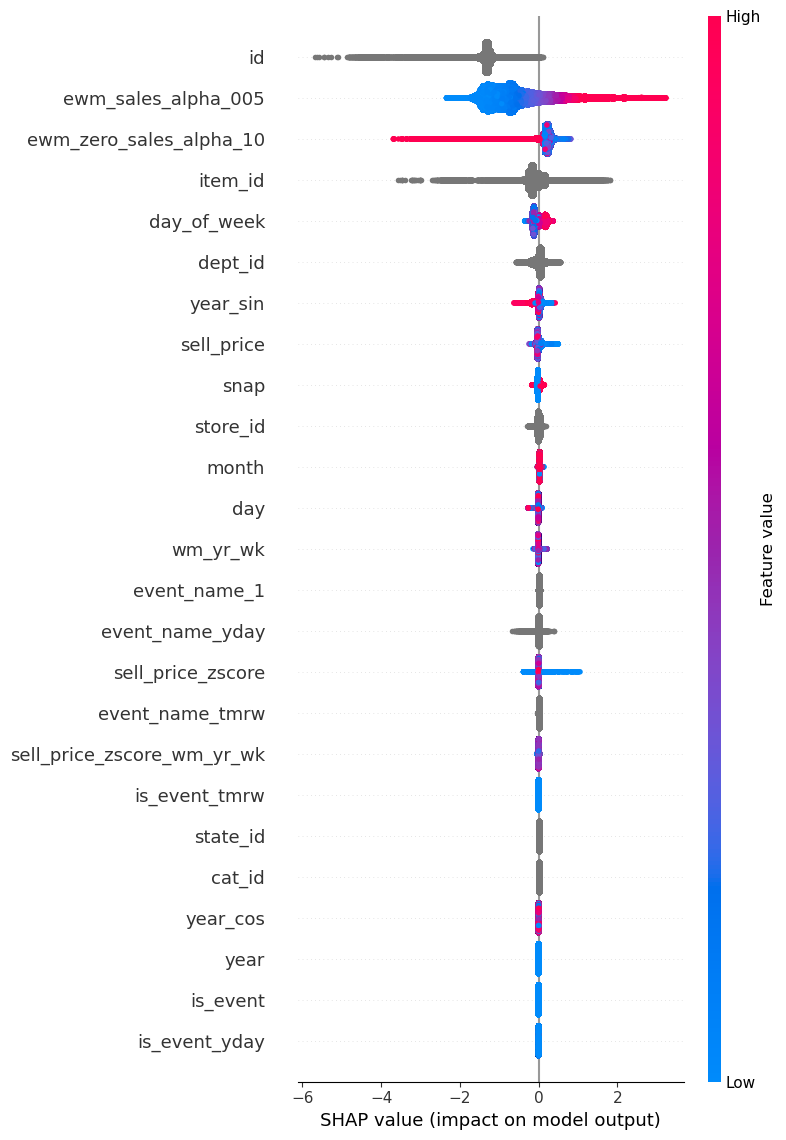

In [54]:
from xgboost import DMatrix
import shap
shap.initjs()

test_dm = DMatrix(X_test, enable_categorical=True)
shap_values = xgb_model.get_booster().predict(test_dm, pred_contribs=True)
shap.summary_plot(shap_values[:,:-1], X_test, max_display=40)